# Phase Shift Approach - Velocity Measurements

Castelletti et al. searches for the correct slope of a surface by sweeping ranges/velocities and finding the correct phase correction by maximizing post-summed SNR. Here, we can employ a similar methodology but to find the correct spacecraft velocity.

- Surface echoes from Europa for ranging measurements will arrive later as the spacecraft moves away from the moon. 
- We can sum the received signals, each shifted with a phase correction $\Delta \phi$, to maximize post-summed SNR.
- We sweep ranging measurements to seek the correct velocities. 

This is advantageous because (i) velocity measurements can occur alongside ranging, without previous constraints from Doppler frequency; (ii) aliased results can be eliminated by comparing with Clipper's orbital properties in SPICE; and (iii) uncertainties in range and velocity can be found, across the parameter space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.ticker as mticker

### 1) Model surface echoes (ranging measurements) from Europa 
Modelling chirps with a changing time delay (depends on Clipper's range), and with amplitude decreasing with $\frac{1}{16 \pi d^4}$.
### 2) Shift surface echoes by phase, for a velocity 
For each of the surface echoes above, shift surface echoes by a phase for each velocity. Change in phase shift = $2 \pi \Delta d / \lambda$ from Sean's paper.

In [2]:
# REASON parameters
Pt = 10 # W
Gt = 10**(6/10) # 6 dB -> B
c = 2.998e8 # m/s
rcs = 2.5e10 # for HF, but we can assume for both

hf_wavelength = c/(9e6) # m
vhf_wavelength = c/(60e6) # m

# Set parameters
hf_pulse_length = 200e-6 # s
hf_repetition_freq = 4000 # Hz
hf_bandwidth = 1e6 # Hz
hf_s = hf_bandwidth/hf_pulse_length
hf_chirp_rate = hf_bandwidth/hf_pulse_length # Hz/s
hf_fc = 0 # Hz #9e6 is true value

vhf_pulse_length = 236e-6 # s
vhf_repetition_freq = 4000 # Hz
vhf_bandwidth = 10e6 # Hz
vhf_s = vhf_bandwidth/vhf_pulse_length
vhf_chirp_rate = vhf_bandwidth/vhf_pulse_length # Hz/s
vhf_fc = 60e6 # Hz

# sampling freqs
# 2x complex-valued baseband sampling rate
hf_fs = 2.4e6 
vhf_fs = 24e6

In [3]:
def radar_equation(Pt, Gt, d, rcs, wavelength):
    # From the gain, determine the effective area of REASON
    Ae = (Gt*wavelength**2)/(4*np.pi)
    
    return ((Pt*Gt)/(4*np.pi*d**2))*((rcs*Ae)/(4*np.pi*d**2)) # return power received

In [4]:
def chirp(s, tau, fs, fc, start, n, phase_shift):
    # s: slope
    # tau: pulse length
    # fs: sample rate
    # fc: center frequency
    # start: starting index of chirp
    # n: the length of the chirp including zero

    dt = 1 / fs
    npts = int(tau * fs)
    t = np.arange(-npts/2, npts/2) * dt
    phase = np.pi * s * t**2 + 2 * np.pi * fc * t + phase_shift
    chirp = np.concatenate([np.zeros(start-1), np.exp(1j * phase), np.zeros(n - len(phase) - start + 1)])

    return chirp

In [5]:
# Modelling ranging measurements for various ranges
def ranging_per_v(start_alt, end_time, sampling_rate_m, vset):
    res = np.array([]) # have multiple pulses then delay each one as altitude changes
    
    range_array = np.arange(start_alt, start_alt + end_time*vset, sampling_rate_m)
    
    t = np.arange(0, end_time, 1/hf_fs) # time at the sampling frequency
    index_per_pulse = int((1/hf_repetition_freq)*hf_fs)
    
    for idx, time in enumerate(np.arange(0, len(t), index_per_pulse)):
        if idx % 1000 == 0: print("Pulse #: " + str(idx))
        #d = range_array[idx]
        #phase_shift = 2*np.pi*(vset*t[idx*index_per_pulse])/hf_wavelength # for chirp signal below 

        # ONE CHIRP
        chirpsig = chirp(hf_s, hf_pulse_length, hf_fs, hf_fc, 1, int((1/hf_repetition_freq)*hf_fs), 0)
        
        # signal spreads out 1/16 pi d^4
        Pr = radar_equation(Pt, Gt, range_array[idx], rcs, hf_wavelength)
        
        res = np.append(res, chirpsig) # in units of AMPLITUDE
    
    pulse_count = idx+1
    
    return res, pulse_count, Pr # keep Pr so that we can convert to power later

In [6]:
# set up range array
hf_Ae = (Gt*hf_wavelength**2)/(4*np.pi)
N_galactic = 10**-17 # W/mhz/m^2
N_power = N_galactic * (hf_bandwidth/1e6) * hf_Ae # W
print("Galactic noise (power): {} W".format(N_power))

start_alt = 40000*1e3 #m
end_time = 2*start_alt/c #s
vset = 4e3 #m/s
sampling_rate_m = vset/hf_repetition_freq
  
res, pulse_count, Pr = ranging_per_v(start_alt, end_time, sampling_rate_m, vset) # assume 4 km/s
noise_power = np.random.normal(loc=N_power, size=len(res)) # in units of amplitude (sqrt(W))

print("Uncompressed P_r/N (power): {:.2f} dB".format(10*np.log10(np.max(np.abs(Pr*res**2))/N_power)))

# Times for pulse train
times = np.linspace(0, pulse_count*(1/hf_repetition_freq), len(res)) 
# final time = number of pulses * repetition freq

# Plot figure
'''
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(times/(1e-6), Pr*res**2 + noise_power, c='gray', label='With noise')
plt.plot(times/(1e-6), Pr*res**2, c='maroon', label='Without noise')
plt.title("HF chirp pulse train \nfrom {:,} to {:,} km".format(start_alt/1e3, (start_alt + end_time*vset)/1e3), fontsize=12)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Power (W)", fontsize = 12)
plt.legend()
'''

Galactic noise (power): 3.5153484038226244e-15 W
Pulse #: 0
Pulse #: 1000
Uncompressed P_r/N (power): -36.09 dB


'\nfig, ax = plt.subplots(figsize=(5,5))\nplt.plot(times/(1e-6), Pr*res**2 + noise_power, c=\'gray\', label=\'With noise\')\nplt.plot(times/(1e-6), Pr*res**2, c=\'maroon\', label=\'Without noise\')\nplt.title("HF chirp pulse train \nfrom {:,} to {:,} km".format(start_alt/1e3, (start_alt + end_time*vset)/1e3), fontsize=12)\nplt.xlabel(r"Time ($\\mu$ s)", fontsize=12)\nplt.ylabel("Power (W)", fontsize = 12)\nplt.legend()\n'

### 3) Pulse compress + estimate the phase correction + SNR
For each surface echoes series, implement pulse compression. Use the maxima of each compressed pulse to estimate the slope of the straight line that travels through, which will be the phase correction. 
Find the final summed, phase-corrected pulse to gather the SNR (power received / noise). 


Hmmm... should i be finding or guessing the phase correction? wouldnt we always be maxing out the snr each time?

In [7]:
# input: res array with pulse train (chirps), estimated phase correction
# output: SNR
from scipy.signal import find_peaks

def get_SNR(res, pulse_count, vtrue, vtest, dtrue, dtest):
    # Create the matched filter
    matchedfilter = np.tile(chirp(hf_s, hf_pulse_length, hf_fs, hf_fc, 1, int((1/hf_repetition_freq)*hf_fs), 0), pulse_count)
    
    # matched filter == fft(signal)*fft(filter) conjugate
    corr = np.fft.fftshift(np.fft.ifft(np.fft.fft(res)*np.conj(np.fft.fft(matchedfilter))))
    
    peaks, _ = find_peaks(corr, distance=int((1/hf_repetition_freq)*hf_fs))

    final_signal = np.zeros(2*int((1/hf_repetition_freq)*hf_fs/3), dtype=complex)
    times = np.arange(0, 1, 1/hf_fs) # array of times, 0 to 1 s
    
    # find peaks (individual compressed pulses)
    #plt.figure()
    #plt.plot(np.abs(corr))
    #plt.scatter(peaks, np.zeros(len(peaks)), c='red', zorder=100)
    index_per_pulse = int((1/hf_repetition_freq)*hf_fs)
    
    # FOR GUESSED VELOCITY 
    # Apply phase correction (for each pulse number)
    # find phase correction for v
    vshift = vtrue - vtest # is this right?
    
    for idx, peak in enumerate(peaks):
        # Define the time size for each pulse (INDEX)
        start = peak-int((1/hf_repetition_freq)*hf_fs/3)
        end = peak+int((1/hf_repetition_freq)*hf_fs/3)
        
        # Extract the pulse data
        pulse = corr[start:end]
        
        # if not enough data just leave it
        if start < 0 or len(pulse) != len(final_signal): 
            continue 
        
        
        
        # what fraction of each pulse to shift?
        phase_correction = ((((2*np.pi*vshift*times[idx*index_per_pulse]/hf_wavelength) % (2*np.pi)) / (2*np.pi))) * len(pulse)
        
        shift = int(phase_correction)
        #print(shift)
        if vshift < 0: # moving further out from europa
            # pad with zeroes to the LEFT as we shift RIGHT
            corrected_pulse = np.pad(pulse, (len(pulse) - shift, 0), 'constant')[:len(pulse)]
        else: # moving closer to europa
            # move pulse back, pad with zeroes on right as we shift LEFT
            corrected_pulse = np.pad(pulse, (0, shift), 'constant')[shift:]
            
        #corrected_pulse = pulse * np.exp(-1j * phase_correction * np.arange(len(pulse)))
        
        #plt.plot(np.real(corrected_pulse))
        
        final_signal += corrected_pulse
    
    # FINAL SUMMED PULSE
    '''
    plt.figure()
    pulse_times = np.arange(0, (2/3)*(1/hf_repetition_freq), 1/hf_fs)
    plt.plot(pulse_times/(1e-6), np.real(final_signal))
    plt.xlabel("Times (microseconds)")
    plt.ylabel("Amplitude")
    plt.title(r'Final Summed Pulse: $v_{{\rm{{guess}}}}$ = {0} km/s'.format(vtest/1e3))
    '''
    
    # shift ENTIRE final pulse with respect to dtrue
    delay_time = 2*dtrue/c
    shift_index = np.argmin(np.abs(times-np.full(len(times), delay_time)))
    # Shift the signal array, pad with zeroes
    shifted_signal = np.concatenate([np.zeros(shift_index-int(len(final_signal)/2)), final_signal, np.zeros(len(times) - shift_index - int(len(final_signal)/2))])
    # max of final signal now aligns with shift_index of shifted_signal
    
    # Shifted signal view
    #plt.figure()
    #plt.plot(times, shifted_signal)
    #plt.xlim(times[shift_index-int(len(final_signal)/2)], times[shift_index+int(len(final_signal)/2)])
    #plt.xlabel("Times (seconds)")
    #plt.ylabel("Amplitude")
    #plt.title("Final Pulse -- After Applying Guessed Altitude/Velocity")
    
    # FIND THE SNR AT GUESSED ALTITUDE!!!!!!!
    # find the SNR at the given guessed altitude
    delay_time_guess = 2*dtest/c
    guess_index = np.argmin(np.abs(times-np.full(len(times), delay_time_guess)))
    amplitude_at_guess = np.abs(shifted_signal[guess_index])
    # AMPLITUDE at GUESS (sqrt(W))
    
    return amplitude_at_guess, times, shifted_signal

0.0006966094049308066


(266836.25, 266852.9166666667)

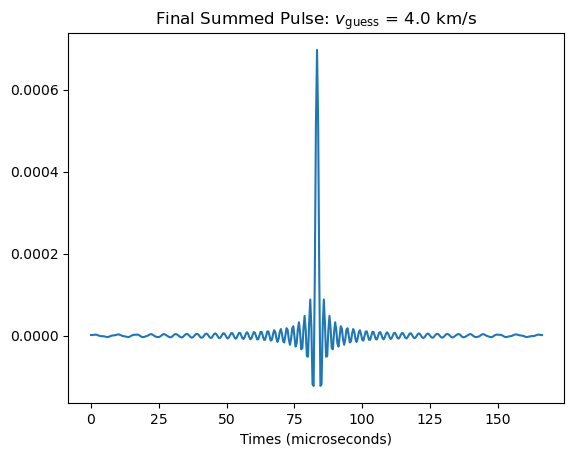

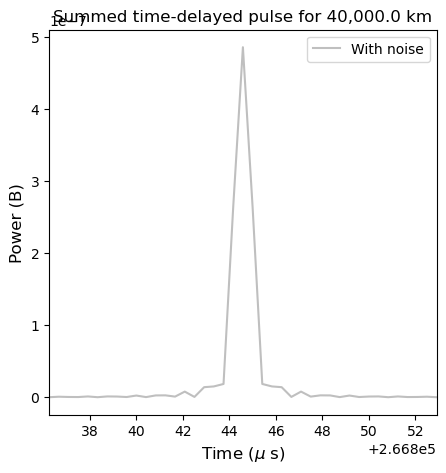

In [54]:
dtrue = 40000e3
vtrue = 4000
#peaks, peak_sum_at_guess, shift_times, shifted_signal = get_SNR(res, pulse_count, 4000, dtrue, dtrue)
noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
amplitude_at_guess, shift_times_noise, shifted_signal_noise = get_SNR(res*np.sqrt(Pr), pulse_count, vtrue, 4.0e3, dtrue, dtrue)
# units of Sqrt(W) -- amplitude
print(amplitude_at_guess)

'''
fig, ax = plt.subplots(figsize=(5,5))
plt.plot(times/(1e-6), np.real(res), c='maroon')
plt.scatter(times[peaks]/(1e-6), np.zeros(len(peaks)), zorder=100)
plt.title("HF chirp pulse train \nfrom {:,} to {:,} km".format(start_alt/1e3, (start_alt + end_time*vset)/1e3), fontsize=12)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Amplitude", fontsize = 12)
'''

fig, ax = plt.subplots(figsize=(5,5))
plt.plot(shift_times_noise/(1e-6), np.abs(shifted_signal_noise)**2, c='gray', label='With noise', alpha=0.5)
#print(np.abs(amplitude_at_guess))
#plt.plot(shift_times/(1e-6), shifted_signal**2, c='maroon', label='Without noise', alpha=0.5)
plt.xlabel(r"Time ($\mu$ s)", fontsize=12)
plt.ylabel("Power (B)", fontsize = 12)
plt.title("Summed time-delayed pulse for {:,} km".format(dtrue/1e3))
plt.legend()
plt.xlim(shift_times_noise[np.argmax(shifted_signal_noise) - 20]/(1e-6), shift_times_noise[np.argmax(shifted_signal_noise) + 20]/(1e-6))

#### For one range, we get SNR per velocity:

Pulse #: 0


Text(0, 0.5, 'SNR')

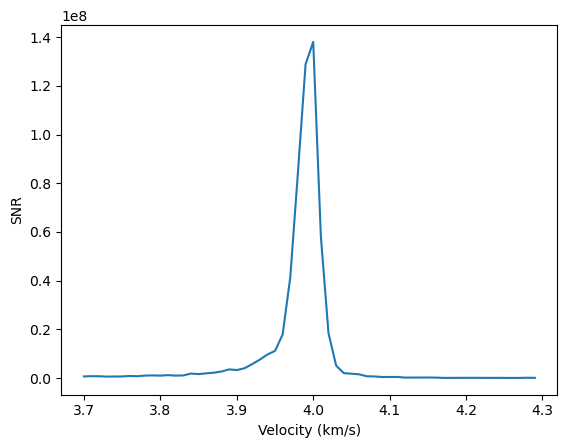

In [41]:
SNR_array = np.array([])
res, pulse_count, Pr = ranging_per_v(start_alt, end_time, 4e3/hf_repetition_freq, 4e3) # assume 4 km/s

for v in np.arange(3.7e3, 4.3e3, 0.01e3):
    noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
    peak_sum, _, shifted_signal  = get_SNR(res*np.sqrt(Pr), pulse_count, 4e3, v, 40000e3, 40000e3) # true alt=40000
    SNR = (np.abs(peak_sum)**2)/N_power # in units of power
    SNR_array = np.append(SNR_array, SNR)

plt.plot(np.arange(3.7e3, 4.3e3, 0.01e3)/1000, SNR_array)
plt.xlabel("Velocity (km/s)")
plt.ylabel("SNR")

Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0
Pulse #: 0

NameError: name 'STOP' is not defined

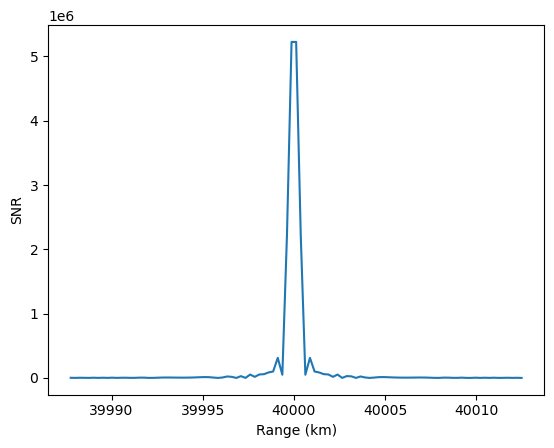

In [42]:
SNR_array = np.array([])
vset = 4e3
dtrue = 40000e3
dx = (1/3)*c*(1/hf_repetition_freq)/2 

for dguess in np.linspace(dtrue-dx, dtrue+dx, 100):
    sampling_rate_m = vset/hf_repetition_freq
    res, pulse_count, Pr = ranging_per_v(40000e3, end_time, sampling_rate_m, vset) # with true values
    noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
    peak_sum, _, shifted_signal = get_SNR(res*np.sqrt(Pr), pulse_count, vset, vset, 40000e3, dguess)
    SNR = (np.abs(peak_sum)**2)/N_power # in units of power
    SNR_array = np.append(SNR_array, SNR)

plt.plot(np.linspace(dtrue-dx, dtrue+dx, 100)[1:]/1000, SNR_array[1:])
plt.xlabel("Range (km)") 
plt.ylabel("SNR")

STOP

### 4) Nested for loop -- many ranges + many velocities
Create a nested for loop implementing each above. Gather the true + recovered ranges, true + recovered velocities (convert phase correction -> velocity), SNR in a 5-value array. 

In [8]:
velocity_guesses = np.linspace(3.7e3, 4.3e3, 100) # m/s

dtrue = 40000e3
vtrue = 4000 # m/s -- the actual velocity
dx = (1/3)*c*(1/hf_repetition_freq)/2 

#end_time = 2*dtrue/c #s -- 40 PULSES
end_time = 0.01 # s

# set up range array
hf_Ae = (Gt*hf_wavelength**2)/(4*np.pi)
N_galactic = 10**-17 # W/mhz/m^2
N_power = N_galactic * (hf_bandwidth/1e6) * hf_Ae # W

distance_guesses = np.linspace(dtrue-dx, dtrue+dx, 100)[1:] #m
#distance_guesses = [dtrue]

final_less = np.zeros((len(distance_guesses), len(velocity_guesses)))

sampling_rate_m = vtrue/hf_repetition_freq
res, pulse_count, Pr = ranging_per_v(dtrue, end_time, sampling_rate_m, vtrue) # with true values
    
for idd, d in enumerate(distance_guesses):
    # get ranging measurements (pulse train)
    for idv, v in enumerate(velocity_guesses):
        noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
        peak_sum, _, _ = get_SNR(res*np.sqrt(Pr) + noise, pulse_count, vtrue, v, dtrue, d)
        SNR = 10*np.log10((np.abs(peak_sum)**2)/N_power + (10**-25))
        final_less[idd, idv] = SNR

Pulse #: 0


[]


ValueError: zero-size array to reduction operation maximum which has no identity

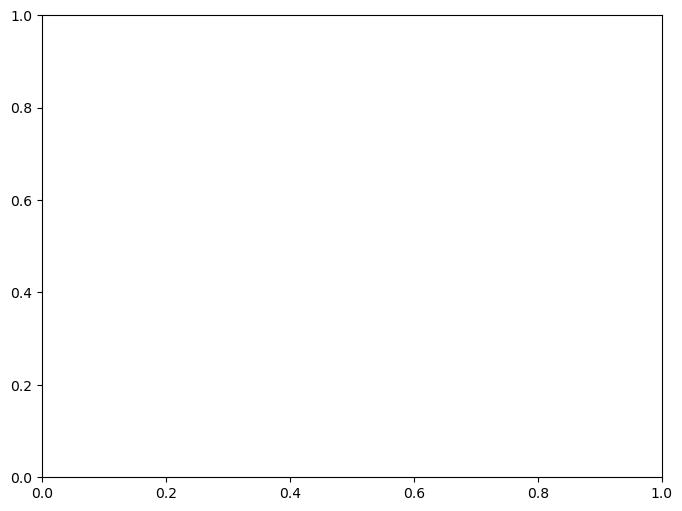

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
print(final_less)
heatmap = ax.imshow(final_less, cmap='viridis', origin="lower",aspect='auto', vmin = 200, 
              vmax = np.max(final_less), extent =[np.min(velocity_guesses/1e3), 
                                     np.max(velocity_guesses/1e3),np.min(distance_guesses/1e3), 
                                     np.max(distance_guesses/1e3)])

# Add colorbar
cbar = plt.colorbar(heatmap)
cbar.set_label('SNR (dB)', rotation=270, labelpad=15)

# Customize the plot
ax.set_ylabel('Ranges (km)')
ax.set_xlabel('Velocities (km/s)')
ax.set_title('Phase Shift Velocity Measurements - {} pulses'.format(pulse_count))

recovered_indices = np.unravel_index(final_less.argmax(), final_less.shape)
print("Recovered range: {:.4f} km".format(distance_guesses[recovered_indices[0]]/1e3))
print("Recovered velocity: {:.4f} km/s".format(velocity_guesses[recovered_indices[1]]/1e3))

### 5) Plot true vs. recovered range + true vs. recovered velocity 
Create true vs. recovered plots, colorcoded by SNR first to visualize general patterns. 

In [ ]:
'''
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
dmaxidx = np.argwhere(final_less==np.amax(final_less, axis=0, keepdims=True))
recovered_ranges = distance_guesses[dmaxidx[:,0]]/1e3

vmaxidx = np.argwhere(final_less==np.amax(final_less, axis=1, keepdims=True))
recovered_velocities = velocity_guesses[vmaxidx[:,1]]/1e3

binsd = np.linspace(np.min(recovered_ranges), np.max(recovered_ranges), 8)
binsv = np.linspace(np.min(recovered_velocities), np.max(recovered_velocities), 8)
ax[0].hist(recovered_ranges, color='#107394', bins=binsd)
ax[0].axvline(dtrue/1e3, ls='--', color='black')
ax[1].hist(recovered_velocities, color='#7b0829', bins=binsv)
ax[1].axvline(vtrue/1e3, ls='--', color='black')

ax[0].set_xlabel("Recovered ranges (km)", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
ax[1].set_xlabel("Recovered velocities (km/s)", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
ax[0].set_xlim(np.min(distance_guesses)/1e3 - 5, np.max(distance_guesses)/1e3 + 5)
ax[1].set_xlim(np.min(velocity_guesses)/1e3 - 0.1, np.max(velocity_guesses)/1e3 + 0.1)


# CALCULATE BIAS AND SCATTER
print(recovered_ranges)
range_bias = np.median(recovered_ranges - np.full(len(recovered_ranges), dtrue/1e3))
range_scatter = np.std(np.abs(recovered_ranges - np.full(len(recovered_ranges), dtrue/1e3)))
velocity_bias = np.median(recovered_velocities - np.full(len(recovered_velocities), vtrue/1e3))
velocity_scatter = np.std(np.abs(recovered_velocities - np.full(len(recovered_velocities), vtrue/1e3)))                    
                       
ax[0].text(x=0.05, y=0.93, s=r'$\mu$ = {:.2f} km'.format(range_bias), transform=ax[0].transAxes, color='#107394')
ax[0].text(x=0.05, y=0.87, s=r'$\sigma$ = {:.3f}'.format(range_scatter), transform=ax[0].transAxes, color='#107394')
ax[1].text(x=0.05, y=0.93, s=r'$\mu$ = {:.2f} km/s'.format(velocity_bias), transform=ax[1].transAxes, color='#7b0829')
ax[1].text(x=0.05, y=0.87, s=r'$\sigma$ = {:.3f}'.format(velocity_scatter), transform=ax[1].transAxes, color='#7b0829')
         
plt.tight_layout()
'''

### 6) Monte Carlo type plot 
(1) Find the brightest SNR point on heatmap -> (2) Rerun new heatmap and get its brightest SNR point -> (3) repeat.
We can see how the brightest SNR point deviates for multiple runs of the heatmap (standard deviation of the movement) to see extent of noise's influence

In [12]:
# store brightest SNR points
all_ranges = np.array([]) # in m
all_velocities = np.array([]) # in m/s

# set up params
dtrue = 40000e3
vtrue = 4000 # m/s -- the actual velocity
dx = (1/3)*c*(1/hf_repetition_freq)/2 
hf_Ae = (Gt*hf_wavelength**2)/(4*np.pi)
N_galactic = 10**-17 # W/mhz/m^2
N_power = N_galactic * (hf_bandwidth/1e6) * hf_Ae # W

n = 1
while n < 100:
    velocity_guesses = np.linspace(3.8e3, 4.2e3, 50) # m/s
    
    end_time = 0.01 # s

    # set up range array
    distance_guesses = np.linspace(dtrue-dx, dtrue+dx, 50)[1:] #m

    final = np.zeros((len(distance_guesses), len(velocity_guesses)))

    sampling_rate_m = vtrue/hf_repetition_freq
    res, pulse_count, Pr = ranging_per_v(dtrue, end_time, sampling_rate_m, vtrue) # with true values

    for idd, d in enumerate(distance_guesses):
        # get ranging measurements (pulse train)
        for idv, v in enumerate(velocity_guesses):
            noise = np.random.normal(loc=np.sqrt(N_power), size=len(res)) # in units of amplitude (sqrt(W))
            peak_sum, _, _ = get_SNR(res*np.sqrt(Pr) + noise, pulse_count, vtrue, v, dtrue, d)
            SNR = 10*np.log10((np.abs(peak_sum)**2)/N_power + (10**-25))
            final[idd, idv] = SNR

    recovered_indices = np.unravel_index(final.argmax(), final.shape)

    print("-- Iteration {} --".format(n))
    print("Recovered range: {:.4f} km".format(distance_guesses[recovered_indices[0]]/1e3))
    print("Recovered velocity: {:.4f} km/s".format(velocity_guesses[recovered_indices[1]]/1e3))

    all_ranges = np.append(all_ranges, distance_guesses[recovered_indices[0]]/1e3)
    all_velocities = np.append(all_velocities, velocity_guesses[recovered_indices[1]]/1e3)
    n += 1


Pulse #: 0
-- Iteration 1 --
Recovered range: 39990.5675 km
Recovered velocity: 4.0041 km/s
Pulse #: 0
-- Iteration 2 --
Recovered range: 39999.7451 km
Recovered velocity: 3.9878 km/s
Pulse #: 0
-- Iteration 3 --
Recovered range: 39992.0971 km
Recovered velocity: 3.9878 km/s
Pulse #: 0
-- Iteration 4 --
Recovered range: 40007.3930 km
Recovered velocity: 4.0041 km/s
Pulse #: 0
-- Iteration 5 --
Recovered range: 39995.6662 km
Recovered velocity: 3.9878 km/s
Pulse #: 0
-- Iteration 6 --
Recovered range: 40007.3930 km
Recovered velocity: 3.9959 km/s
Pulse #: 0
-- Iteration 7 --
Recovered range: 40006.8832 km
Recovered velocity: 3.9959 km/s
Pulse #: 0
-- Iteration 8 --
Recovered range: 39996.1760 km
Recovered velocity: 3.9878 km/s
Pulse #: 0
-- Iteration 9 --
Recovered range: 39998.2155 km
Recovered velocity: 4.0041 km/s
Pulse #: 0
-- Iteration 10 --
Recovered range: 40002.2944 km
Recovered velocity: 3.9796 km/s
Pulse #: 0
-- Iteration 11 --
Recovered range: 39988.0182 km
Recovered velocity

KeyboardInterrupt: 

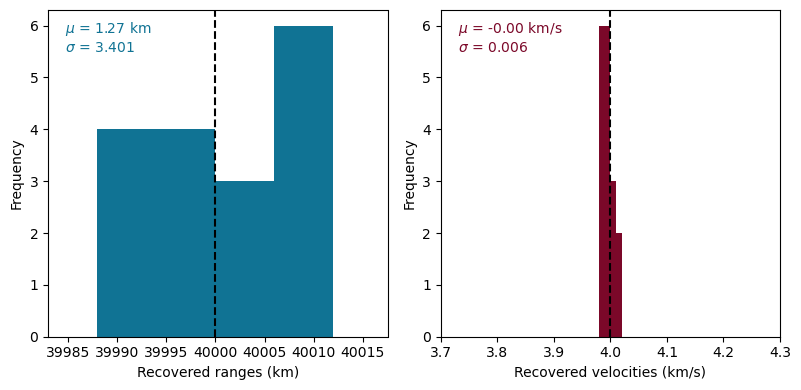

In [13]:
import math

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
N_bins = math.ceil(np.sqrt(n)) # general policy -- number of bins = round up sqrt(number of data)

binsd = np.linspace(np.min(all_ranges), np.max(all_ranges), N_bins)
binsv = np.linspace(np.min(all_velocities), np.max(all_velocities), N_bins)
ax[0].hist(all_ranges, color='#107394', bins=binsd)
ax[0].axvline(dtrue/1e3, ls='--', color='black')
ax[1].hist(all_velocities, color='#7b0829', bins=binsv)
ax[1].axvline(vtrue/1e3, ls='--', color='black')

ax[0].set_xlabel("Recovered ranges (km)", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
ax[1].set_xlabel("Recovered velocities (km/s)", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
ax[0].set_xlim(np.min(distance_guesses)/1e3 - 5, np.max(distance_guesses)/1e3 + 5)
ax[1].set_xlim(np.min(velocity_guesses)/1e3 - 0.1, np.max(velocity_guesses)/1e3 + 0.1)

# CALCULATE BIAS AND SCATTER
range_bias = np.median(all_ranges - np.full(len(all_ranges), dtrue/1e3))
range_scatter = np.std(np.abs(all_ranges - np.full(len(all_ranges), dtrue/1e3)))
velocity_bias = np.median(all_velocities - np.full(len(all_velocities), vtrue/1e3))
velocity_scatter = np.std(np.abs(all_velocities - np.full(len(all_velocities), vtrue/1e3)))                    
                       
ax[0].text(x=0.05, y=0.93, s=r'$\mu$ = {:.2f} km'.format(range_bias), transform=ax[0].transAxes, color='#107394')
ax[0].text(x=0.05, y=0.87, s=r'$\sigma$ = {:.3f}'.format(range_scatter), transform=ax[0].transAxes, color='#107394')
ax[1].text(x=0.05, y=0.93, s=r'$\mu$ = {:.2f} km/s'.format(velocity_bias), transform=ax[1].transAxes, color='#7b0829')
ax[1].text(x=0.05, y=0.87, s=r'$\sigma$ = {:.3f}'.format(velocity_scatter), transform=ax[1].transAxes, color='#7b0829')
         
plt.tight_layout()